## OPTECH. Use Case 1
### Phase 1
#### Based on paper: X. Liu, B. Wang  and Z. Yang, "Virtual Network Embedding Based on Topology Potential, " Entropy 2018, 20(12), 941.

In [127]:
# Libraries needed
import networkx as nx
import math
import random
import numpy as np
import time
import matplotlib.pyplot as plt

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import pickle
import sqlite3

## SCENARIO


In [128]:
# Generate the attributes 'location' and 'cpu' of the nodes of a network
def GenerateAttribNetworkNodes( G, minCPU, maxCPU, ):
    distribCPU = np.random.randint( minCPU, maxCPU, len(G.nodes()) ) # distribution of nodes CPU
    for n in list(G.nodes()):
        G.nodes[n]['loc']=(0,0) 
    for n in list(G.nodes()):
        position = False
        l = [G.nodes[n]['loc'] for n in list(G.nodes())]
        while not position:
            x = np.random.randint( minX, maxX, 1)
            y = np.random.randint( minY, maxY, 1)
            if (x,y) not in l:
                G.nodes[n]['loc']=(x,y)
                position = True
        G.nodes[n]['cpu'] = distribCPU[n]


    return G


# Generate the attributes 'distance' and 'bw' of the links of a network
def GenerateAttribNetworkLinks( G, minBW, maxBW ):
    distribBW = np.random.randint( minBW, maxBW, len(G.edges()) ) # distribution of links BW
    for idx, link in enumerate(list(G.edges())):
        G.edges[link]['dist'] = Distance( G.nodes[link[0]]['loc'], G.nodes[link[1]]['loc'] )
        bw = int(round(distribBW[idx]))
        G.edges[(link[0],link[1])]['bw'] = distribBW[idx]
        G.edges[(link[1],link[0])]['bw'] = distribBW[idx]

    return G


# Calculate the distance between two nodes
def Distance(p1, p2):
    return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)

In [129]:
# Location of nodes (physical and virtuals)
minX = 1
maxX= 1000
minY = 1
maxY = 1000

### PHYSICAL NETWORK


In [130]:
NumNodes = 20
Degree = 10

# Nodes CPU
minCPU = 50
maxCPU = 100

# Link BW
minBW= 50
maxBW = 100

def GeneratePhysicalNetwork(): 
    # Generate a random physical network with NumNodes nodes and NumNodes*Degree/2 bidirectional links
    Gp = nx.random_regular_graph( Degree, NumNodes )
    # Fill the nodes and links attributes
    GenerateAttribNetworkNodes( Gp, minCPU, maxCPU )
    GenerateAttribNetworkLinks( Gp, minBW, maxBW )

    # Relabel the number of nodes to start from 1 (instead of 0)
    Gp = nx.convert_node_labels_to_integers(Gp, first_label=1, ordering='sorted', label_attribute=None)

    return Gp
    

/tmp/ipykernel_2897/2473718380.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)


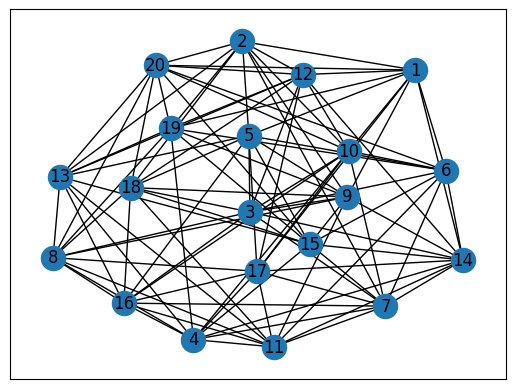

In [131]:
# Physical network
Gp=GeneratePhysicalNetwork()
nx.draw_networkx(Gp)

In [132]:
print(Gp.nodes)

[8, 18, 4, 14, 6, 11, 1, 20, 9, 19, 3, 12, 7, 13, 16, 5, 10, 17, 2, 15]


In [133]:
print(Gp.edges)

[(8, 18), (8, 11), (8, 20), (8, 13), (8, 17), (8, 4), (8, 19), (8, 3), (8, 16), (8, 9), (18, 2), (18, 15), (18, 11), (18, 3), (18, 5), (18, 9), (18, 12), (18, 16), (18, 20), (4, 14), (4, 7), (4, 16), (4, 11), (4, 13), (4, 15), (4, 17), (4, 10), (4, 19), (14, 7), (14, 15), (14, 17), (14, 3), (14, 9), (14, 6), (14, 12), (14, 1), (14, 11), (6, 11), (6, 1), (6, 20), (6, 15), (6, 10), (6, 19), (6, 7), (6, 3), (6, 5), (11, 16), (11, 13), (11, 7), (11, 9), (11, 17), (1, 17), (1, 10), (1, 19), (1, 12), (1, 5), (1, 9), (1, 2), (1, 20), (20, 19), (20, 10), (20, 2), (20, 15), (20, 13), (20, 12), (9, 19), (9, 2), (9, 3), (9, 5), (9, 15), (19, 13), (19, 12), (19, 2), (19, 15), (3, 12), (3, 5), (3, 7), (3, 16), (3, 10), (12, 17), (12, 2), (12, 10), (12, 13), (7, 16), (7, 2), (7, 15), (7, 17), (7, 10), (13, 2), (13, 16), (13, 15), (13, 5), (16, 17), (16, 5), (16, 10), (5, 2), (5, 15), (5, 17), (10, 17), (10, 2)]


### VIRTUAL NETWORK

In [134]:
minvCPU = 1
maxvCPU = 50

minvBW= 1
maxvBW = 50

minNumNodesV = 4
maxNumNodesV = 8


Distance_tolerance = 400


def GenerateVirtualNetwork( NumVNodes ):
    degree = (NumVNodes-1)/2
    # Number of nodes x degree has to be an even number
    product =  math.ceil(NumVNodes*degree/2.0) * 2
    # Thus, the degree has to be:
    degree = math.ceil(product/NumVNodes)
    Gv = nx.random_regular_graph( degree, NumVNodes )
    # Fill the nodes and links attributes
    GenerateAttribNetworkNodes( Gv, minvCPU, maxvCPU )
    GenerateAttribNetworkLinks( Gv, minvBW, maxvBW )
    # We will save the physical node where the virtual node is embedded
    for n in list(Gv.nodes()):
        Gv.nodes[n]['PNode'] = 0

    # Relabel the number of nodes to start from 1 (instead of 0)
    Gv=nx.convert_node_labels_to_integers(Gv, first_label=1, ordering='sorted', label_attribute=None)
    
    return Gv
    

/tmp/ipykernel_2897/2473718380.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)


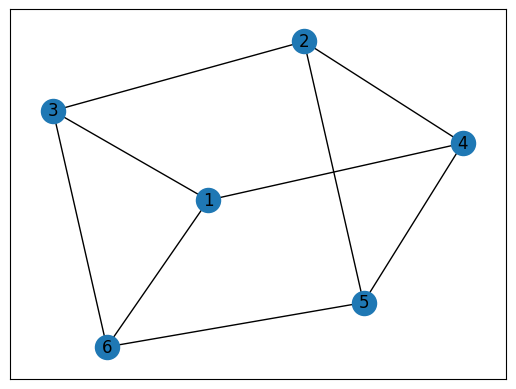

In [135]:
numTotalRequest = 1

VNRarri = 1

distribNumNodes = np.random.randint( minNumNodesV, maxNumNodesV, numTotalRequest )

NumVNodes = distribNumNodes[0]
Gv = GenerateVirtualNetwork(NumVNodes)
nx.draw_networkx(Gv)

## MODEL

In [136]:
print(Gv.nodes)


[2, 3, 4, 5, 1, 6]


In [137]:
# Create a mathematical model (MILP)
model = ConcreteModel()

#################
## Parameters  ##
#################

# Set of phy and vir nodes
model.N = RangeSet(1,NumNodes)
model.V = RangeSet(1,NumVNodes)

# set of phy nodes and edges
model.Np = Set(initialize = list(Gp.nodes))
model.Ep = Set(initialize = list(Gp.edges))

# set of vir nodes and edges
model.Nv = Set(initialize = list(Gv.nodes))
model.Ev = Set(initialize = list(Gv.edges))
               

# phy attributes
model.cpu_p = Param(model.Np, initialize = nx.get_node_attributes(Gp, 'cpu'))
model.bw_p = Param(model.Ep, initialize = nx.get_edge_attributes(Gp, 'bw'))
model.loc_p = Param(model.Np, initialize = nx.get_node_attributes(Gp, 'loc'))


# vir attributes
model.cpu_v = Param(model.Nv, initialize = nx.get_node_attributes(Gv, 'cpu'))
model.bw_v = Param(model.Ev, initialize = nx.get_edge_attributes(Gv, 'bw'))
model.loc_v = Param(model.Nv, initialize = nx.get_node_attributes(Gv, 'loc'))


# Maximum distance between physical nodes and virtual nodes
model.D = Param(initialize=400)


################
## Variables  ##
################

model.x = Var(model.Np, model.Nv, within=Binary, initialize=0)
model.y = Var(model.Ep, model.Ev, within=Binary, initialize=0)


############
## MODEL  ##
############

# OBJECTIVE FUNCION
def Objective_rule(model):
    return sum(model.x[i,s]*model.cpu_v[s] for i in model.Np for s in model.Nv) + \
               sum(model.y[i,j,s,t]*model.bw_v[s,t] for i,j in model.Ep for s,t in model.Ev)
model.Objective = Objective(rule=Objective_rule, sense=minimize)

# CONSTRAINTS
def cpu_rule(model, i, s):
    return (model.x[i,s]*model.cpu_v[s])<= (model.cpu_p[i])
model.cpu_rule = Constraint(model.Np, model.Nv, rule=cpu_rule)

def distance_rule(model,i,s):
    return model.x[i,s]*Distance(model.loc_v[s], model.loc_p[i]) <= Distance_tolerance

model.distance_rule = Constraint(model.Np, model.Nv, rule = distance_rule)

# one v node to at most 1 p node
def vlimit_rule(model,i):
    return sum(model.x[i,s] for s in model.Nv) <= 1
model.vlimit = Constraint(model.Np, rule = vlimit_rule)

# node embedding
def node_rule(model,s):
    return sum(model.x[i,s] for i in model.Np) == 1
model.node_rule = Constraint(model.Nv, rule = node_rule)

def bw_rule(model,i,j):
    return sum(model.y[i,j,s,t]*model.bw_v[s,t] for s,t in model.Ev) <= model.bw_p[i,j]
model.bw_rule = Constraint(model.Ep, rule=bw_rule)

def flow_rule(model,i,s,t):
    in1 = sum(model.y[i,j,s,t] for j in model.Np if (i,j) in model.Ep)
    in2 = sum(model.y[j,i,s,t] for j in model.Np if (j,i) in model.Ep)
    inflow = in1 - in2
    outflow = model.x[i,s]-model.x[i,t]
    return inflow == outflow
    
model.flow = Constraint(model.Np, model.Ev, rule=flow_rule)

/tmp/ipykernel_2897/2473718380.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)


## SOLVE THE MODEL

In [138]:
solver = SolverFactory('glpk')
results=solver.solve(model)

## PRINT RESULTS

In [139]:
# Check if the solver found an optimal solution
if results.solver.status == SolverStatus.ok and results.solver.termination_condition == TerminationCondition.optimal:
    print("Optimal solution found!\n")

    # Print node-to-node mappings (x variable)
    print("Node Mappings (Physical -> Virtual):")
    for i in model.Np:
        for s in model.Nv:
            if model.x[i, s].value > 0.5:  # If the variable is set to 1
                print(f"Physical node {i} is mapped to Virtual node {s}")

    # Print edge-to-edge mappings (y variable)
    print("\nEdge Mappings (Physical -> Virtual):")
    for i, j in model.Ep:
        for s, t in model.Ev:
            if model.y[i, j, s, t].value > 0.5:  # If the variable is set to 1
                print(f"Physical edge ({i}, {j}) is mapped to Virtual edge ({s}, {t})")

else:
    print("No optimal solution found. Solver status:", results.solver.status)
    print("Termination condition:", results.solver.termination_condition)


Optimal solution found!

Node Mappings (Physical -> Virtual):
Physical node 6 is mapped to Virtual node 2
Physical node 20 is mapped to Virtual node 4
Physical node 19 is mapped to Virtual node 3
Physical node 13 is mapped to Virtual node 1
Physical node 10 is mapped to Virtual node 5
Physical node 2 is mapped to Virtual node 6

Edge Mappings (Physical -> Virtual):
Physical edge (6, 20) is mapped to Virtual edge (2, 4)
Physical edge (6, 10) is mapped to Virtual edge (2, 5)
Physical edge (6, 19) is mapped to Virtual edge (2, 3)
Physical edge (20, 10) is mapped to Virtual edge (4, 5)
Physical edge (20, 13) is mapped to Virtual edge (4, 1)
Physical edge (19, 13) is mapped to Virtual edge (3, 1)
Physical edge (19, 2) is mapped to Virtual edge (3, 6)
Physical edge (13, 2) is mapped to Virtual edge (1, 6)
Physical edge (10, 2) is mapped to Virtual edge (5, 6)


In [140]:
total_cost = model.Objective()
print(f"Total cost of the Virtual Network Embedding (VNE): {total_cost}")

Total cost of the Virtual Network Embedding (VNE): 317.0
